# Challenge 3

by: Marion Pillas, Nicola Borghi and Paul Lagabbe



# Question 1 & 2

First :
- Import librairies
- Download the H1 data



In [ ]:
! pip install -q 'lalsuite==6.82' 'PyCBC==1.18.0' 'gwpy==2.0.2'


In [ ]:
# import libraries

import pylab
import numpy as np
import matplotlib.pyplot as plt
from pycbc.frame import read_frame
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.filter import matched_filter

In [ ]:
# import data

file_name = '/content/challenge3.gwf'
H1_channel = 'H1:CHALLENGE3'

hdata_raw = read_frame(file_name, H1_channel)


- Plot the H1 data in the time-domain


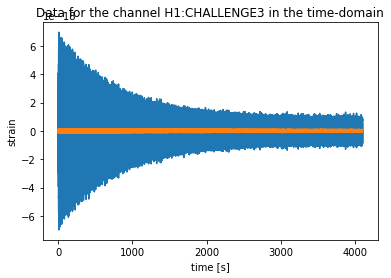

In [ ]:
# Remove the low frequency content
hdata = highpass(hdata_raw, 20.0)
hdata = hdata.crop(2,2)

time = hdata.sample_times
# Plot in the time domain
plt.figure()
plt.plot(hdata_raw.sample_times, hdata_raw)
plt.plot(time, hdata)
plt.xlabel('time [s]')
plt.ylabel('strain')
plt.title('Data for the channel H1:CHALLENGE3 in the time-domain')
plt.show()

In [ ]:
# compute some useful variables

delta_t = hdata.delta_t
delta_f = hdata.delta_f
sample_rate = hdata.sample_rate

- Compute the psd

In [ ]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density (2.2 method)

# We use 4 second samples of our time series in Welch method.
psd = hdata.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
psd = interpolate(psd, delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, int(4 * sample_rate), low_frequency_cutoff=20)

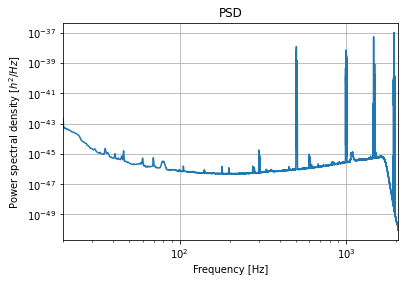

In [ ]:
# define frequency variable
frequency = np.arange(0, sample_rate / 2. + delta_f / 2., delta_f)
# plot psd
pylab.figure()
plt.grid()
plt.plot(frequency, psd)
plt.xlabel("Frequency [Hz]")
plt.ylabel('Power spectral density [$h^2/Hz$]')
plt.title('PSD')
plt.xlim(20,sample_rate / 2.)
plt.xscale('log')
plt.yscale('log')
plt.show()

- Get the template waveform for 2 BBH with masses of 10 solar masses.

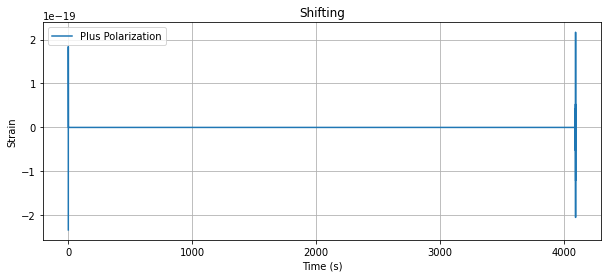

In [ ]:
# Simulate the BBH signal :

import pylab
from pycbc.waveform import get_td_waveform

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt", # we chose this approximant since masses are above 4 solar masses
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/hdata_raw.get_sample_rate(),
                         f_lower=20)



# resize the data arrays
hp.resize(len(hdata))

# shift the signal so the merge time is exactily 0s
hp = hp.cyclic_time_shift(hp.start_time)

pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
plt.title("Shifting")
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
pylab.grid()
pylab.show()



- Compute the SNR vs time
- Find the peak, its SNR and the corresponding merger time.

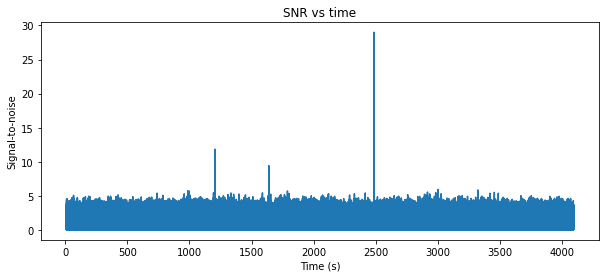

We found a signal at 2483.967529296875s with SNR 29.009069148336227


In [ ]:
snr = matched_filter(hp, hdata, psd=psd, low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why are we taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.title("SNR vs time")
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))

# Results of questions 1 & 2 : 

We found a signal at 2483.967529296875s with SNR 29.009069148336227.

# For fun (1):

Display the signal as sound like in challenge 1.

In [ ]:
# for fun, the "pop"

from scipy.io.wavfile import write
import IPython

signal, _ = get_td_waveform(approximant="SEOBNRv4_opt", # approximant for total mass above 4 solar masses
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/hdata_raw.get_sample_rate(),
                         f_lower=20)

scaled = np.int16(signal/np.max(np.abs(signal.numpy())) * 32767)


write('signal.wav', int(signal.sample_rate), scaled)

IPython.display.Audio('signal.wav')


# For fun (2):

Plot the q_transform of the data around the merger time of the signal.

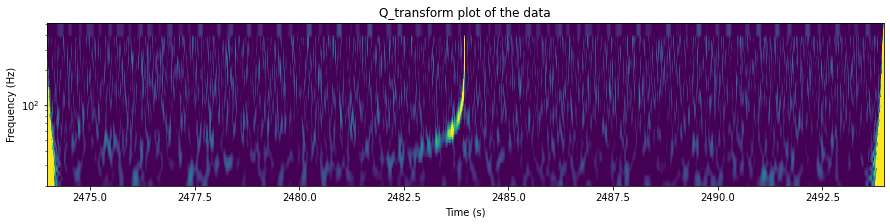

In [ ]:
#We choose a window of 20s around the peak we found in the previous question

start = time - 10
end = time + 10
dt = hdata_raw.get_delta_t()
signal = hdata_raw.time_slice(start, end, mode='floor')

t, f, p = signal.qtransform(delta_t=dt, logfsteps=100, qrange=(10, 11), frange=(20, 512))
pylab.figure(figsize=[15, 3])
pylab.title('Q_transform plot of the data')
pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
pylab.yscale('log')
pylab.xlabel('Time (s)')
pylab.ylabel('Frequency (Hz)')
pylab.show()